In [1]:
# 필요한 라이브러리 임포트
import numpy as np
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib
import sys
import random
from sklearn.model_selection import KFold

# 캐싱된 모듈 삭제
if 'models' in sys.modules:
    del sys.modules['models']
if 'Segdataset' in sys.modules:
    del sys.modules['Segdataset']

# 다시 임포트
from models import CNN
from Segdataset import SegDataset,read_train_file_list
from torch.utils.data import DataLoader

In [2]:
print(CNN)

<class 'models.CNN1'>


In [3]:
class Args:
    def __init__(self):
        self.data_root = '/workspace/dataset/tess_datasets/train/train_data'
        self.save_root = 'checkpoints/CNN'
        self.epoch = 50
        self.lr = 3e-5
        self.batch_size = 32
        self.num_workers = 8
        self.random_seed = 1
        self.n_mfcc = 16
        self.n_splits = 5

opt = Args()


In [4]:
def main():
    print("Training by CNN1")

    # 저장 디렉토리 없으면 생성
    if not os.path.exists(opt.save_root):
        os.makedirs(opt.save_root)
        print('Created directory:', opt.save_root)

    # 데이터셋 로딩
    mfcc_list, emotion_list = read_train_file_list(root=opt.data_root, n_mfcc=opt.n_mfcc)

    # KFold cross-validation
    kf = KFold(n_splits=opt.n_splits, shuffle=True, random_state=opt.random_seed)

    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

    print(f"Using device: {device}")

    all_train_epoch_loss = []
    all_test_epoch_loss = []
    all_test_epoch_accuracy_emotion = []

    return kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


In [5]:
def train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion):
    for fold, (train_idx, val_idx) in enumerate(kf.split(mfcc_list)):
        print(f"Fold {fold + 1}/{opt.n_splits}")

        # 모델을 fold마다 초기화
        model = CNN().to(device)

        # 학습/검증 데이터로 쪼개기
        train_mfcc = [mfcc_list[i] for i in train_idx]
        train_emotion = [emotion_list[i] for i in train_idx]
        val_mfcc = [mfcc_list[i] for i in val_idx]
        val_emotion = [emotion_list[i] for i in val_idx]

        train_set = SegDataset(train_mfcc, train_emotion)
        val_set = SegDataset(val_mfcc, val_emotion)

        # Create dataloaders
        train_loader = DataLoader(train_set, batch_size=opt.batch_size, shuffle=True, drop_last=True, num_workers=opt.num_workers)
        val_loader = DataLoader(val_set, batch_size=opt.batch_size, shuffle=False, drop_last=True, num_workers=opt.num_workers)

        # 각 fold에 따라 pos_weight 동적으로 설정
        num_pos = sum(em == 1 for em in train_emotion)
        num_neg = sum(em == 0 for em in train_emotion)
        pos_weight = torch.tensor([num_neg / num_pos]).to(device) if num_pos > 0 else torch.tensor([1.0]).to(device)

        # loss and optimizer 선언
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
        optimizer = optim.Adam(model.parameters(), lr=opt.lr)

        # 현재 폴드 값들 저장
        train_losses = []
        val_losses = []
        val_accuracies = []

        best_val_loss = float('inf')
        best_epoch = 0

        for epo in range(opt.epoch):
            model.train()
            train_loss = 0

            for index, (mfcc, emotion) in enumerate(train_loader):
                mfcc, emotion = mfcc.to(device), emotion.to(device)
                optimizer.zero_grad()
                output_emotion = model(mfcc)

                emotion = emotion.float()
                loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # 검증
            model.eval()
            val_loss = 0
            correct_emotion = 0
            total = 0
            with torch.no_grad():
                for mfcc, emotion in val_loader:
                    mfcc, emotion = mfcc.to(device), emotion.to(device)
                    output_emotion = model(mfcc)
                    emotion = emotion.float()

                    loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                    val_loss += loss.item()

                    predicted_emotion = (torch.sigmoid(output_emotion[:, 0]) > 0.56).float()
                    correct_emotion += (predicted_emotion == emotion).sum().item()
                    total += emotion.size(0)

            val_accuracy = correct_emotion / total
            print(f"Fold {fold + 1} | Epoch {epo} | Train Loss: {train_loss / len(train_loader)} | Val Loss: {val_loss / len(val_loader)} | Val Accuracy: {val_accuracy}")

            # 모델 저장
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epo
                torch.save(model.state_dict(), os.path.join(opt.save_root, f'fold_{fold + 1}_best_epoch.pth'))

            # Track the training and validation losses and accuracies for plotting later
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_accuracy)

        print(f"Fold{fold+1} best epoch : {best_epoch} ")

        all_train_epoch_loss.append(train_losses)
        all_test_epoch_loss.append(val_losses)
        all_test_epoch_accuracy_emotion.append(val_accuracies)

        plot_fold_performance(train_losses, val_losses, val_accuracies, fold)

    return all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


In [6]:
def plot_fold_performance(train_losses, val_losses, val_accuracies, fold):
    # Fold별로 그래프를 그리기 (Colab에서 바로 확인 가능하도록)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Training by CNN1
Using device: cuda
Fold 1/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 1 | Epoch 0 | Train Loss: 0.6234984770417213 | Val Loss: 0.593208487544741 | Val Accuracy: 0.5825892857142857
Fold 1 | Epoch 1 | Train Loss: 0.6114767502461161 | Val Loss: 0.5902339475495475 | Val Accuracy: 0.5513392857142857
Fold 1 | Epoch 2 | Train Loss: 0.6059638698186193 | Val Loss: 0.5868591027600425 | Val Accuracy: 0.5267857142857143
Fold 1 | Epoch 3 | Train Loss: 0.600866108068398 | Val Loss: 0.5810639730521611 | Val Accuracy: 0.5714285714285714
Fold 1 | Epoch 4 | Train Loss: 0.5941394663282803 | Val Loss: 0.5725430590765817 | Val Accuracy: 0.640625
Fold 1 | Epoch 5 | Train Loss: 0.5844095987933022 | Val Loss: 0.5583722804273877 | Val Accuracy: 0.7433035714285714
Fold 1 | Epoch 6 | Train Loss: 0.5708759959254947 | Val Loss: 0.5435397241796766 | Val Accuracy: 0.7857142857142857
Fold 1 | Epoch 7 | Train Loss: 0.5539479718676635 | Val Loss: 0.5236118180411202 | Val A

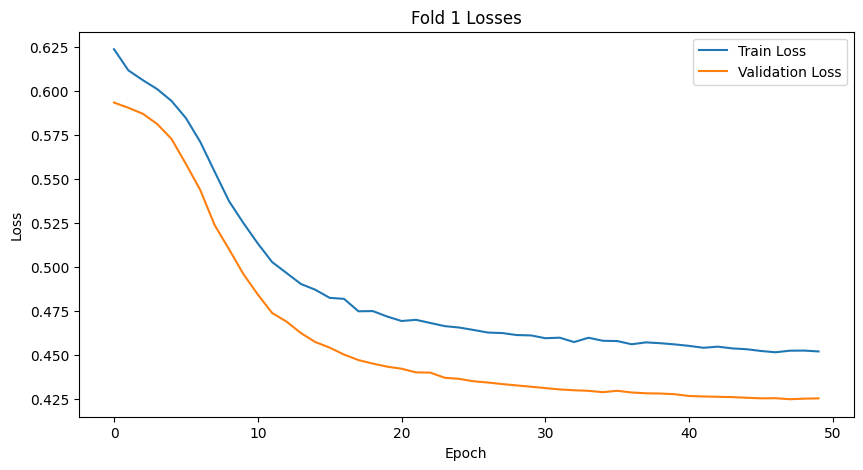

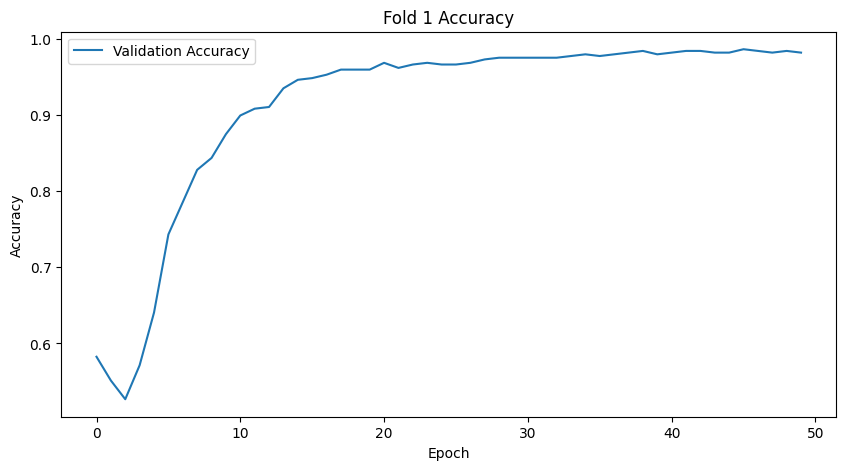

Fold 2/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 2 | Epoch 0 | Train Loss: 0.6020252693976674 | Val Loss: 0.6037045291491917 | Val Accuracy: 0.546875
Fold 2 | Epoch 1 | Train Loss: 0.5899861167584147 | Val Loss: 0.5933101177215576 | Val Accuracy: 0.4486607142857143
Fold 2 | Epoch 2 | Train Loss: 0.5834628380835056 | Val Loss: 0.5872377455234528 | Val Accuracy: 0.5513392857142857
Fold 2 | Epoch 3 | Train Loss: 0.5769533014723233 | Val Loss: 0.5797973700932094 | Val Accuracy: 0.6495535714285714
Fold 2 | Epoch 4 | Train Loss: 0.5687482399599892 | Val Loss: 0.5694466275828225 | Val Accuracy: 0.7700892857142857
Fold 2 | Epoch 5 | Train Loss: 0.5557573294000966 | Val Loss: 0.5539722229753222 | Val Accuracy: 0.8660714285714286
Fold 2 | Epoch 6 | Train Loss: 0.5392700204891818 | Val Loss: 0.5359075729336057 | Val Accuracy: 0.9107142857142857
Fold 2 | Epoch 7 | Train Loss: 0.5215219551963466 | Val Loss: 0.5194765031337738 | Val Accuracy: 0.921875
Fold 2 | Epoch 8

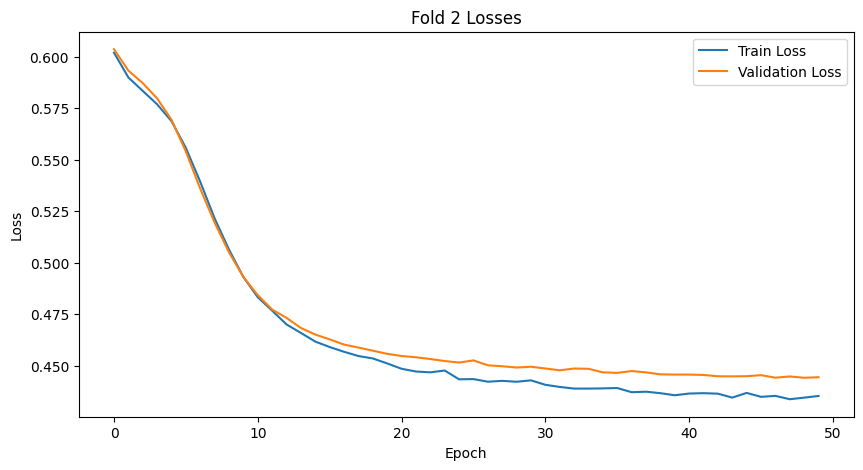

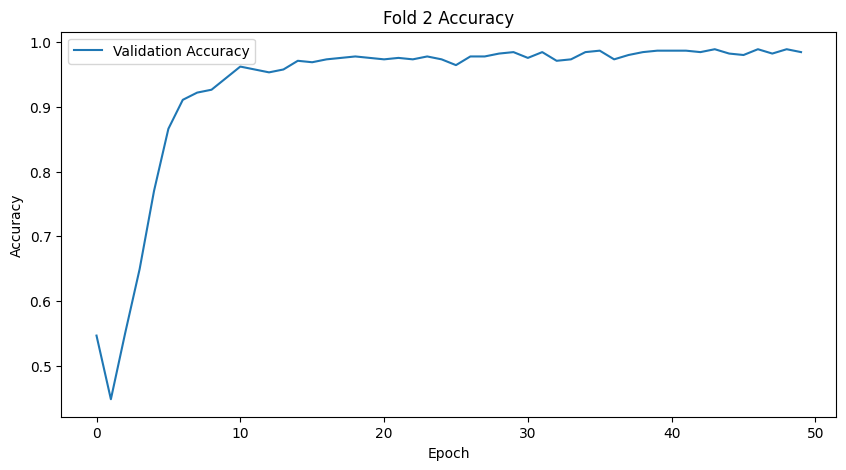

Fold 3/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 3 | Epoch 0 | Train Loss: 0.5949822951640401 | Val Loss: 0.6066584033625466 | Val Accuracy: 0.5334821428571429
Fold 3 | Epoch 1 | Train Loss: 0.5811570052589689 | Val Loss: 0.5953601471015385 | Val Accuracy: 0.6183035714285714
Fold 3 | Epoch 2 | Train Loss: 0.5755740052887371 | Val Loss: 0.5890384997640338 | Val Accuracy: 0.5892857142857143
Fold 3 | Epoch 3 | Train Loss: 0.5708922296762466 | Val Loss: 0.5834001728466579 | Val Accuracy: 0.6294642857142857
Fold 3 | Epoch 4 | Train Loss: 0.5645360765712601 | Val Loss: 0.5759897785527366 | Val Accuracy: 0.7120535714285714
Fold 3 | Epoch 5 | Train Loss: 0.5553412213921547 | Val Loss: 0.5648774291787829 | Val Accuracy: 0.8571428571428571
Fold 3 | Epoch 6 | Train Loss: 0.5409312253551823 | Val Loss: 0.5507122597524098 | Val Accuracy: 0.9017857142857143
Fold 3 | Epoch 7 | Train Loss: 0.5244478562048503 | Val Loss: 0.534091653568404 | Val Accuracy: 0.90625
Fold 3 |

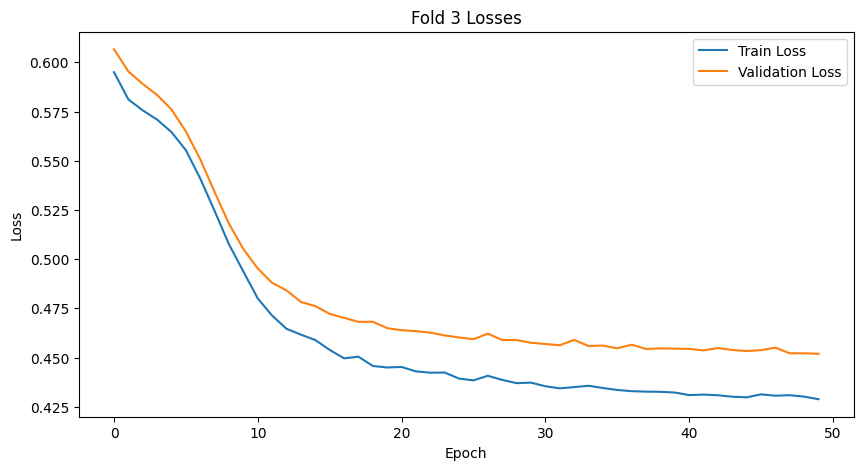

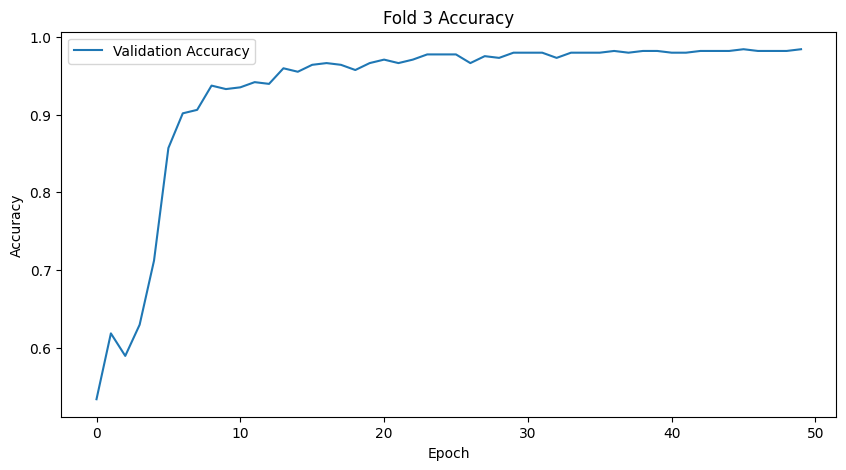

Fold 4/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 4 | Epoch 0 | Train Loss: 0.6067726835608482 | Val Loss: 0.6006956441061837 | Val Accuracy: 0.5736607142857143
Fold 4 | Epoch 1 | Train Loss: 0.5944891614573342 | Val Loss: 0.5923368547643934 | Val Accuracy: 0.4486607142857143
Fold 4 | Epoch 2 | Train Loss: 0.5884541049599648 | Val Loss: 0.5873446379389081 | Val Accuracy: 0.44642857142857145
Fold 4 | Epoch 3 | Train Loss: 0.5835127830505371 | Val Loss: 0.5819412980760846 | Val Accuracy: 0.5915178571428571
Fold 4 | Epoch 4 | Train Loss: 0.5771816915699414 | Val Loss: 0.574471150125776 | Val Accuracy: 0.7678571428571429
Fold 4 | Epoch 5 | Train Loss: 0.566757470369339 | Val Loss: 0.5616825648716518 | Val Accuracy: 0.8549107142857143
Fold 4 | Epoch 6 | Train Loss: 0.5519557786839349 | Val Loss: 0.5448765009641647 | Val Accuracy: 0.875
Fold 4 | Epoch 7 | Train Loss: 0.5345592232687133 | Val Loss: 0.5279103772980827 | Val Accuracy: 0.8861607142857143
Fold 4 | E

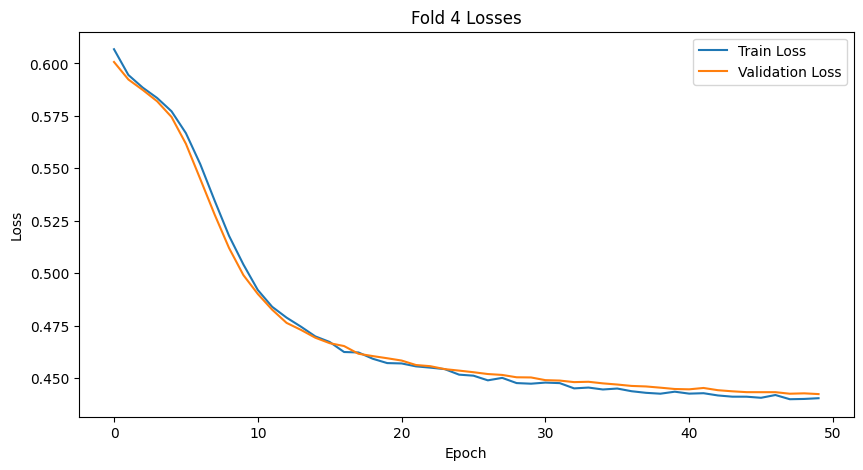

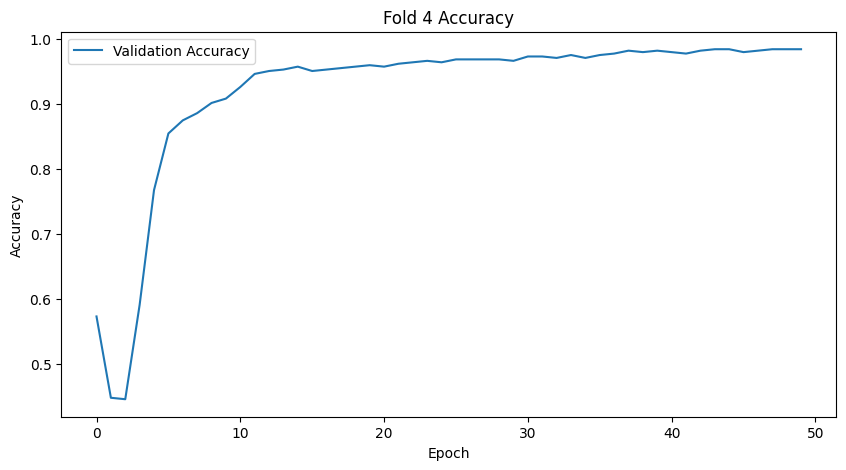

Fold 5/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 5 | Epoch 0 | Train Loss: 0.6168201257075582 | Val Loss: 0.5984769548688617 | Val Accuracy: 0.5825892857142857
Fold 5 | Epoch 1 | Train Loss: 0.5999643728137016 | Val Loss: 0.5896079114505223 | Val Accuracy: 0.6830357142857143
Fold 5 | Epoch 2 | Train Loss: 0.5922886686665672 | Val Loss: 0.5840393049376351 | Val Accuracy: 0.6116071428571429
Fold 5 | Epoch 3 | Train Loss: 0.5862581527658871 | Val Loss: 0.5772371675286975 | Val Accuracy: 0.6584821428571429
Fold 5 | Epoch 4 | Train Loss: 0.5780880876949855 | Val Loss: 0.5678107695920127 | Val Accuracy: 0.7633928571428571
Fold 5 | Epoch 5 | Train Loss: 0.5671748891472816 | Val Loss: 0.5556960999965668 | Val Accuracy: 0.8013392857142857
Fold 5 | Epoch 6 | Train Loss: 0.5530016720294952 | Val Loss: 0.5408056931836265 | Val Accuracy: 0.8348214285714286
Fold 5 | Epoch 7 | Train Loss: 0.5378399480666433 | Val Loss: 0.5239081744636808 | Val Accuracy: 0.8727678571428

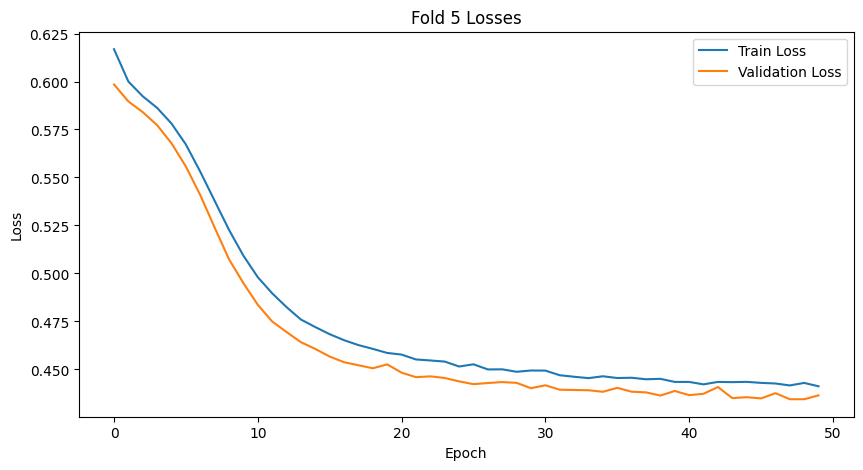

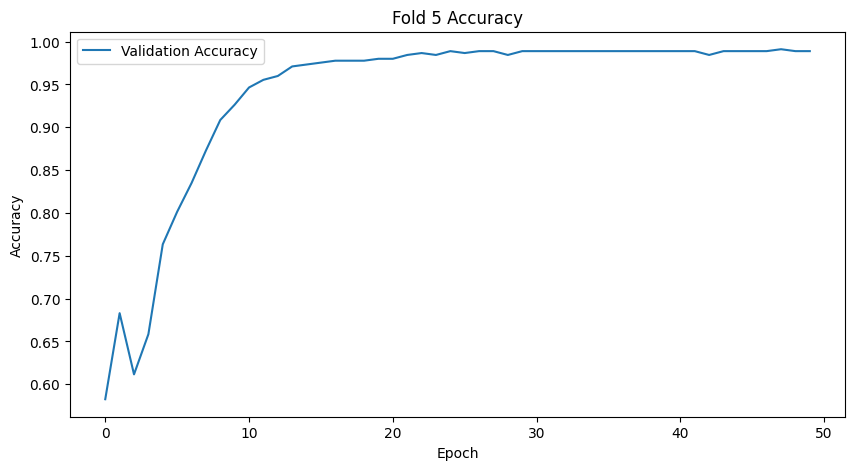

In [7]:
if __name__ == '__main__':
    kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion = main()
    train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion)